## **1. Preparation**

### 1.1. Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications import ResNet101V2
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math
import os
import zipfile
import random

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter, defaultdict
from google.colab import drive
from shutil import copy2

### 1.2. Check Available GPU

Checking if a GPU is available. If not, that's okay.

In [ ]:
print("GPU available:", tf.config.list_physical_devices('GPU'))

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 1.3. Defining Constant Variables

In [ ]:
BATCH_SIZE = 16
IMG_SIZE = 448

### 1.5. Using TFDS

Install TensorFlow Datasets

In [ ]:
!pip install tensorflow-datasets

Load the dataset.

In [ ]:
dataset_name = "cassava"

# load as image & label pairs
# include dataset metadata
dataset, info = tfds.load(
    dataset_name,
    as_supervised = True,
    with_info = True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

View dataset splits

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='cassava',
    full_name='cassava/0.1.0',
    description="""
    Cassava consists of leaf images for the cassava plant depicting healthy and
    four (4) disease conditions; Cassava Mosaic Disease (CMD), Cassava Bacterial
    Blight (CBB), Cassava Greem Mite (CGM) and Cassava Brown Streak Disease (CBSD).
    Dataset consists of a total of 9430 labelled images.
    The 9430 labelled images are split into a training set (5656), a test set(1885)
    and a validation set (1889). The number of images per class are unbalanced with
    the two disease classes CMD and CBSD having 72% of the images.
    """,
    homepage='https://www.kaggle.com/c/cassava-disease/overview',
    data_dir='/root/tensorflow_datasets/cassava/0.1.0',
    file_format=tfrecord,
    download_size=1.26 GiB,
    dataset_size=1.26 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'labe

Check splits data.

In [ ]:
print(info.splits)

{Split('train'): <SplitInfo num_examples=5656, num_shards=8>, Split('test'): <SplitInfo num_examples=1885, num_shards=4>, Split('validation'): <SplitInfo num_examples=1889, num_shards=4>}


Defining the datasets :
- train_data
- validation_data
- test_data

In [ ]:
unfiltered_train_data = dataset['train']
validation_data = dataset['validation']
test_data = dataset['test']

Defining function to limit the dataset will be used. Max 800 images per class.

In [ ]:
class_counters = defaultdict(int)

def filter_train_data(image, label):
  global class_encounters

  if class_counters[label.numpy()] < 800:
    class_counters[label.numpy()] += 1
    return True

  return False

Apply the filter function.

In [ ]:
train_data = unfiltered_train_data.filter(
    lambda image, label: tf.py_function(
        func = filter_train_data,
        inp = [image, label],
        Tout = tf.bool
    )
)

Checking the number of samples per class in the filtered dataset.

In [ ]:
class_counts = Counter()
class_names = info.features['label'].names

for _, label in train_data:
  class_counts[int(label.numpy())] += 1

print("Class counts after filtering:", {class_names[k]: v for k, v in class_counts.items()})

Class counts after filtering: {'cmd': 800, 'cgm': 773, 'healthy': 316, 'cbsd': 800, 'cbb': 466}


Preprocess function.

In [ ]:
def preprocess(image, label):
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = image / 255.0

  return image, label

Augmentation and normalize data function.

In [ ]:
def augment(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

  return image, label

In [ ]:
train_data = train_data.map(preprocess).map(augment).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
validation_data = validation_data.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Checking images

In [ ]:
for image, label in train_data.take(1):
    print(f"Original image shape: {image.shape}")

Original image shape: (16, 448, 448, 3)


## 2. Training

### 2.1. Building CNN Model

#### Bulinding CNN model

Define model function.

In [ ]:
def define_model():
  # load EfficientNetB4 as Backbone
  base_model = EfficientNetB4(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
  base_model.trainable = False

  # custom layers
  input_layers = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  x = base_model(input_layers, training=False)

  # add more custom layers
  conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
  conv1 = tf.keras.layers.BatchNormalization()(conv1)
  pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

  conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(pool1)
  conv2 = tf.keras.layers.BatchNormalization()(conv2)
  pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

  flatten = tf.keras.layers.Flatten()(pool2)

  dense1 = tf.keras.layers.Dense(256, activation='relu')(flatten)

  dropout = tf.keras.layers.Dropout(0.5)(dense1)

  outputs = tf.keras.layers.Dense(5, activation='softmax')(dropout)

  model = tf.keras.Model(inputs=input_layers, outputs=outputs)

  return model

In [ ]:
def define_model(base_model):
  # custom layers
  input_layers = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  x = base_model(input_layers, training=False)

  ga_pool2D = layers.GlobalAveragePooling2D()(x)
  dropout = layers.Dropout(0.5)(ga_pool2D)
  outputs = layers.Dense(info.features['label'].num_classes, activation='softmax')(dropout)

  model = tf.keras.Model(inputs=input_layers, outputs=outputs)

  return model

Defining the model.

In [ ]:
# load EfficientNetB4 as Backbone
base_model = ResNet101V2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model = define_model(base_model)

Model summary

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 448, 448, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet101v2 (Functional)             │ (None, 14, 14, 2048)        │      42,626,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │          10,245 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,636,805 (162.65 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 42,626,560 (162.61 MB)

### 2.2. Compiling and Training the Model

Compiling the model

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

Initial training

In [ ]:
history = model.fit(
    train_data,
    validation_data = validation_data,
    epochs = 10
)

Epoch 1/10
     11/Unknown 44s 2s/step - accuracy: 0.2364 - loss: 1.9375   

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.2405 - loss: 1.9263 - val_accuracy: 0.0651 - val_loss: 2.2259
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0651 - val_loss: 2.2259
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 94s 9s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0651 - val_loss: 2.2259
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0651 - val_loss: 2.2259
Epoch 5/10


Fine tuning

In [ ]:
# Unfreeze the base model for fine-tuning
model.get_layer('efficientnetb4').trainable = True

# Optionally, freeze all but the last N layers
for layer in model.get_layer('efficientnetb4').layers[:-20]:
    layer.trainable = False

# Recompile the Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-Tune the Model
history_fine_tune = model.fit(
    train_data,
    validation_data = validation_data,
    epochs = 20,
    initial_epoch = 10
)


Epoch 11/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 176s 365ms/step - accuracy: 0.4385 - loss: 1.4096 - val_accuracy: 0.4696 - val_loss: 1.3416
Epoch 12/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 136s 252ms/step - accuracy: 0.4623 - loss: 1.3552 - val_accuracy: 0.4696 - val_loss: 1.3378
Epoch 13/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 141s 248ms/step - accuracy: 0.4659 - loss: 1.3487 - val_accuracy: 0.4696 - val_loss: 1.3354
Epoch 14/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 142s 249ms/step - accuracy: 0.4663 - loss: 1.3510 - val_accuracy: 0.4696 - val_loss: 1.3371
Epoch 15/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 142s 250ms/step - accuracy: 0.4621 - loss: 1.3545 - val_accuracy: 0.4696 - val_loss: 1.3366
Epoch 16/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 89s 251ms/step - accuracy: 0.4696 - loss: 1.3464 - val_accuracy: 0.4696 - val_loss: 1.3337
Epoch 17/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 89s 249ms/step - accuracy: 0.4655 - loss: 1.3484 - val_accuracy: 0.4696 - val_loss: 1.3333
Epoch 18/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 142s 250ms/step - accuracy: 0.

### 2.3. Evaluating the Model

Evaluating the model

In [ ]:
loss, accuracy = model.evaluate(test_data)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 49s 297ms/step - accuracy: 0.4651 - loss: 1.3571
Test Loss: 1.3444372415542603
Test Accuracy: 0.47002652287483215


## 3. Visualizations

### 3.1. Training Metrics

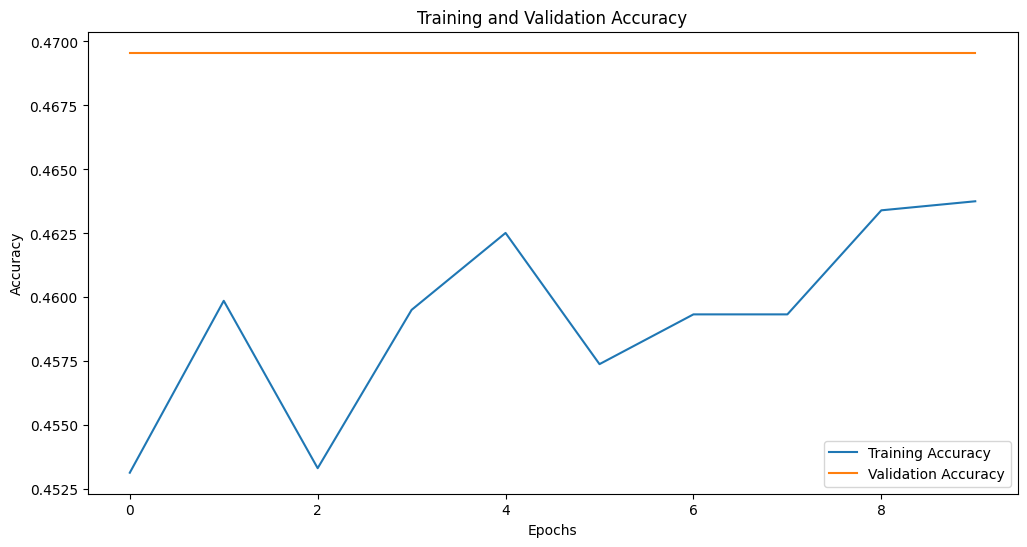

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

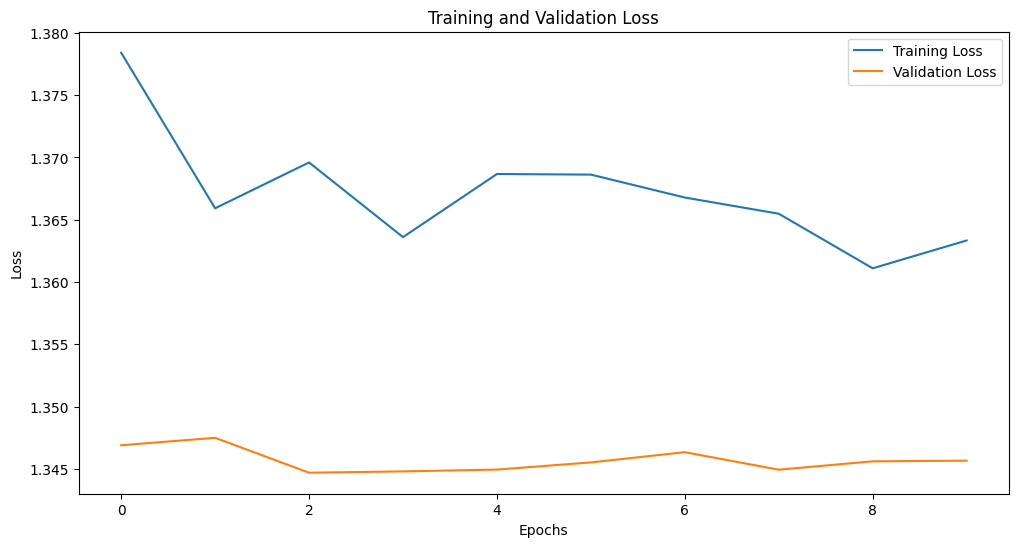

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3.1. Class Distribution

#### Non TFDS

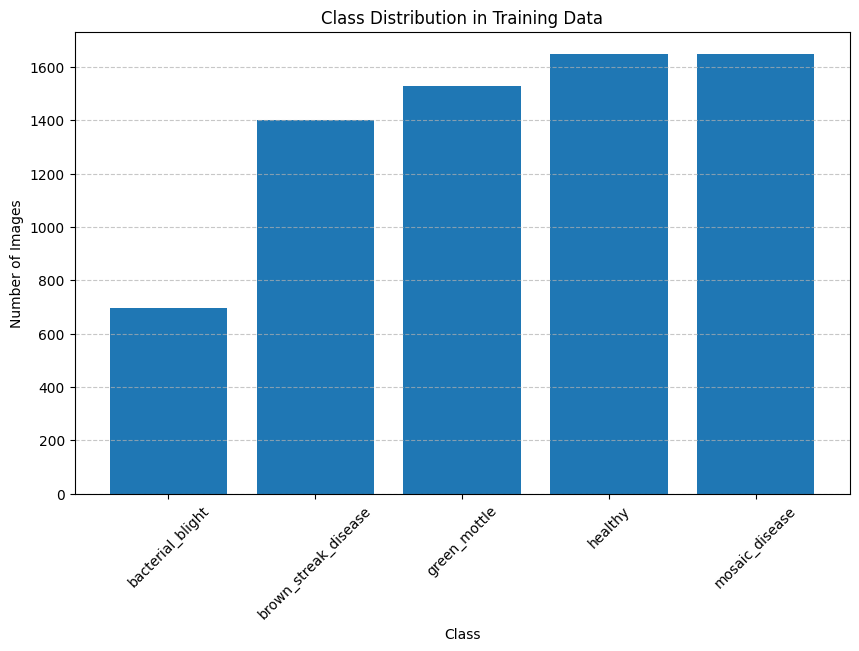

In [ ]:
# Get class indices and map them to class names
class_indices = train_data.class_indices  # Mapping of class names to numeric labels
class_names = list(class_indices.keys())  # List of class names

# Count occurrences of each class
class_counts = Counter(train_data.classes)  # train_data.classes gives class indices for each file

# Map counts to class names
class_counts_named = {class_names[idx]: count for idx, count in class_counts.items()}

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts_named.keys(), class_counts_named.values())
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#### TFDS

Checking the labels

In [ ]:
for _, label in train_data.take(5):  # Inspect first 5 samples
    print(f"Label: {label}, Shape: {label.shape}")

Label: [2 0 2 3 1 2 3 3 3 3 3 1 1 0 1 3 1 3 1 3 3 1 0 2 1 3 3 1 3 1 1 3], Shape: (32,)
Label: [1 3 3 2 3 2 3 1 1 1 1 1 1 3 3 3 2 3 3 3 3 3 3 1 1 3 3 3 4 1 3 3], Shape: (32,)
Label: [1 1 1 3 3 1 1 4 2 2 3 3 1 3 3 3 3 1 3 3 3 3 2 1 2 2 1 3 0 3 3 3], Shape: (32,)
Label: [1 4 4 3 1 3 3 0 3 1 1 3 1 1 1 1 2 1 4 2 3 3 2 3 2 4 3 3 1 3 3 3], Shape: (32,)
Label: [1 3 3 3 2 1 2 3 1 3 3 3 0 1 1 3 3 1 3 1 0 3 3 1 1 4 1 3 3 3 3 1], Shape: (32,)


Visualization

Class distribution: {'cmd': 2658, 'cgm': 773, 'cbb': 466, 'cbsd': 1443, 'healthy': 316}


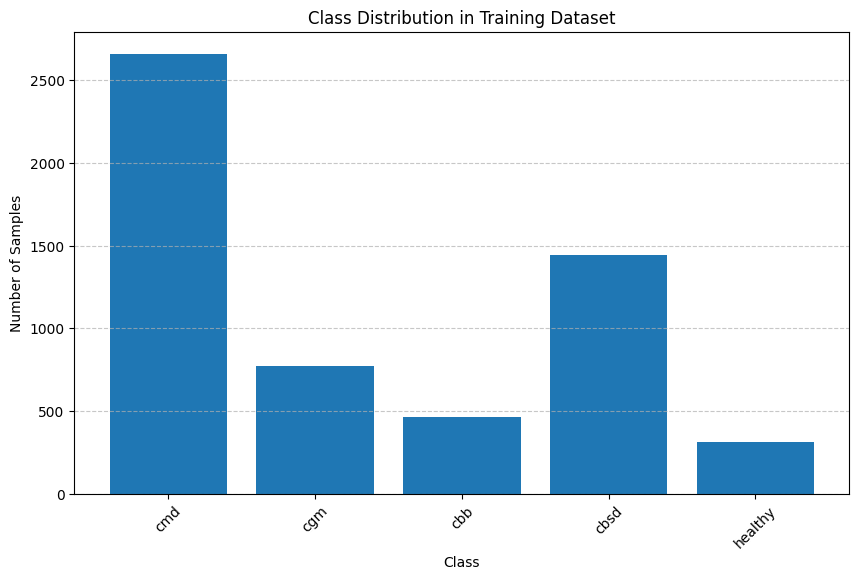

In [ ]:
class_names = info.features['label'].names

# Count class instances
class_counts = Counter()
for _, labels in train_data:  # Iterate over batches
    for label in labels.numpy():  # Iterate through each label in the batch
        class_counts[int(label)] += 1

# Map class indices to class names
class_distribution = {class_names[k]: v for k, v in class_counts.items()}
print("Class distribution:", class_distribution)

# Visualize the class distribution
classes = list(class_distribution.keys())
counts = list(class_distribution.values())

plt.figure(figsize=(10, 6))
plt.bar(classes, counts)
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 3.2. Sample Images

#### Non TFDS

In [ ]:
# Initialize figure
plt.figure(figsize=(10, 10))

# Fetch and display 16 images
for i in range(16):
    img, label = next(train_data)  # Use the built-in `next()` function
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[0])  # Display the first image in the batch
    plt.title(f"Label: {np.argmax(label[0])}")  # Show the label of the first image
    plt.axis('off')

plt.tight_layout()
plt.show()

#### TFDS

In [ ]:
class_names = info.features['label'].names

for images, labels in train_data.take(1):  # Take one batch
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display 9 images
        plt.subplot(3, 3, i + 1)

        # Unnormalize the image (convert back to [0, 255])
        img = (images[i].numpy() * 255).astype("uint8")  # Rescale and convert to uint8

        plt.imshow(img)
        plt.title(f"Label: {class_names[labels[i].numpy()]}")
        plt.axis('off')
    plt.show()

### 3.3. Confusion Matrix

#### Non TFDS

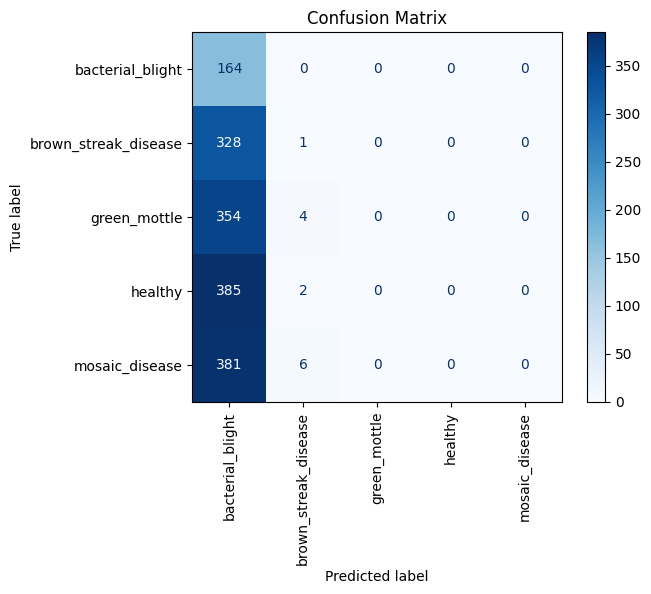

In [ ]:
y_true = validation_data.classes
y_pred = np.argmax(model.predict(validation_data, verbose=0), axis=1)

cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(validation_data.class_indices.keys()))
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

#### TFDS

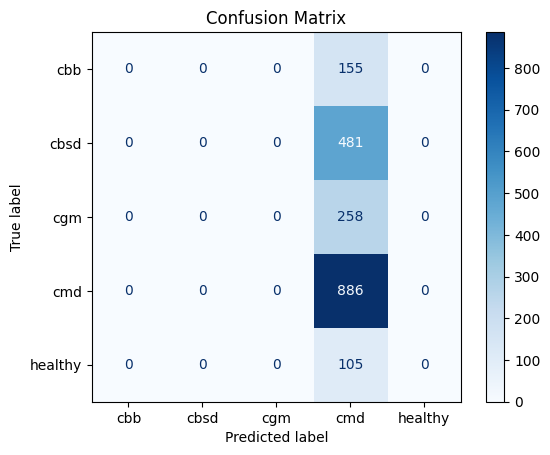

In [ ]:
y_true = []
y_pred = []

for images, labels in test_data:
    predictions = model.predict(images, verbose=0)  # Get predictions
    y_true.extend(labels.numpy())  # Append true labels
    y_pred.extend(np.argmax(predictions, axis=1))  # Append predicted labels

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class names
class_names = info.features['label'].names

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### 3.4. Classification Report

#### Non TFDS

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


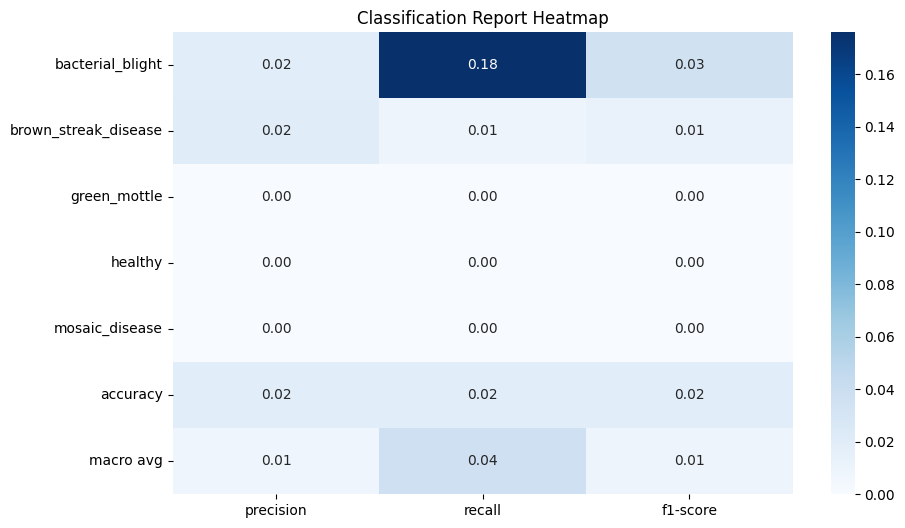

In [ ]:
# Assuming y_true and y_pred are both 1D arrays of class indices
report = classification_report(
    y_true,  # True class indices
    y_pred,  # Predicted class indices
    target_names=list(test_data.class_indices.keys()),  # Class names
    output_dict=True  # To get the report as a dictionary
)

# Convert to a DataFrame for visualization
df = pd.DataFrame(report).transpose()

# Heatmap for precision, recall, and F1-score
plt.figure(figsize=(10, 6))
sns.heatmap(df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()

### 3.5. Misclassified Samples

#### Non TFDS

In [ ]:
# Extract test images and true labels
x_test = []
y_true = []

for imgs, labels in test_data:  # Iterate over batches
    x_test.extend(imgs)          # Add images to x_test
    y_true.extend(np.argmax(labels, axis=1))  # Convert one-hot to class index

x_test = np.array(x_test)
y_true = np.array(y_true)

# Get predictions
y_pred = np.argmax(model.predict(test_data), axis=1)

# Identify misclassified samples
misclassified = []
for i in range(len(y_true)):
    if y_true[i] != y_pred[i]:  # Compare true and predicted labels
        misclassified.append((x_test[i], y_true[i], y_pred[i]))

# Convert class indices to a list for label lookup
class_names = list(test_data.class_indices.keys())

# Display misclassified images
plt.figure(figsize=(10, 10))
for i, (img, true_label, pred_label) in enumerate(misclassified[:16]):  # Display first 16
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_names[true_label]}, Pred: {class_names[pred_label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

#### TFDS

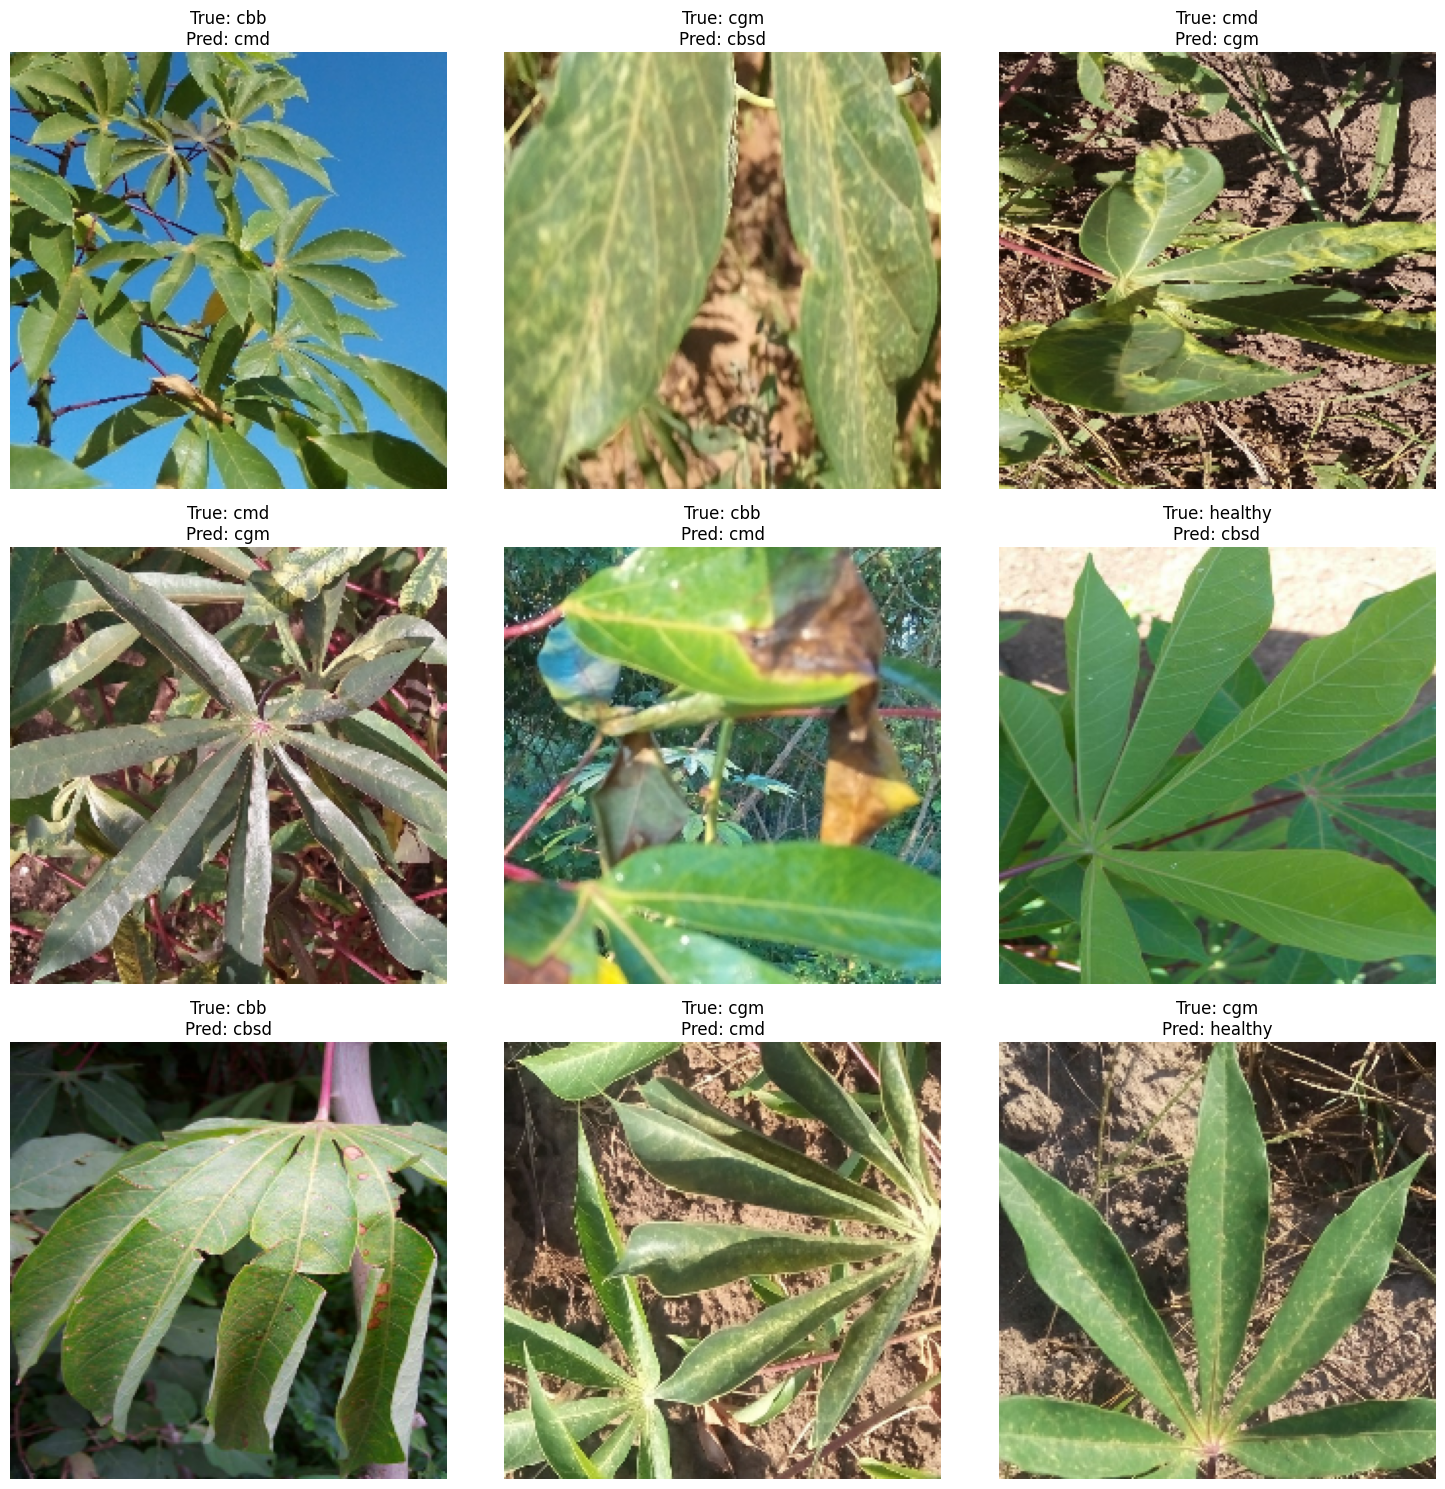

In [ ]:
# Arrays to store misclassified samples
misclassified_images = []
misclassified_true_labels = []
misclassified_pred_labels = []

# Generate predictions and find misclassified samples
for images, labels in test_data:
    predictions = model.predict(images, verbose=0)
    pred_labels = np.argmax(predictions, axis=1)

    for i in range(len(labels)):
        true_label = labels.numpy()[i]
        pred_label = pred_labels[i]

        if true_label != pred_label:  # If misclassified
            misclassified_images.append(images[i].numpy())  # Save the image
            misclassified_true_labels.append(true_label)  # Save the true label
            misclassified_pred_labels.append(pred_label)  # Save the predicted label

# Visualize misclassified samples
class_names = info.features['label'].names

plt.figure(figsize=(15, 15))
num_samples = min(9, len(misclassified_images))

for i in range(num_samples):
    plt.subplot(3, 3, i + 1)
    img = misclassified_images[i] * 255.0  # Unnormalize for display
    plt.imshow(img.astype("uint8"))
    true_label = class_names[misclassified_true_labels[i]]
    pred_label = class_names[misclassified_pred_labels[i]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()